In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as ski
import fastremap
import cellpose
from cellpose import models, io



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	darwin 
python version: 	3.13.3 
torch version:  	2.7.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [3]:
images_dir = Path("/Users/elisagozlan/Desktop/GP16 astrocytes/laminin B1 + GFAP + DAPI")
samples = [d.name for d in images_dir.iterdir() if d.is_dir()]

samples

['M Cre', 'M No Cre', 'CTRL AB 2', 'F Cre', 'F no cre']

In [4]:
def fields_of_sample(sample_dir):
    return [d.name for d in sample_dir.iterdir() if d.is_dir()]


sample_fields = {}
for sample in samples:
    sample_fields[sample] = fields_of_sample(images_dir / sample)

sample_fields

{'M Cre': ['1', '4', '3', '2', '5'],
 'M No Cre': ['1', '4', '3', '2', '5'],
 'CTRL AB 2': [],
 'F Cre': ['1', '4', '3', '2', '5'],
 'F no cre': ['1', '4', '3', '2', '5']}

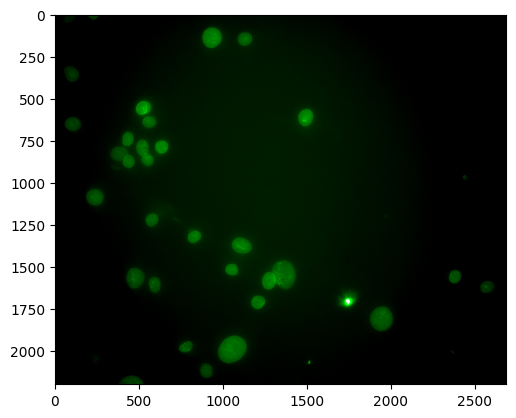

In [76]:
sample = "M No Cre"
field = "1"

image_path = images_dir / sample / field / "laminin B1.tif"
image = ski.io.imread(image_path)

plt.figure()
plt.imshow(image)

1.0
255.0


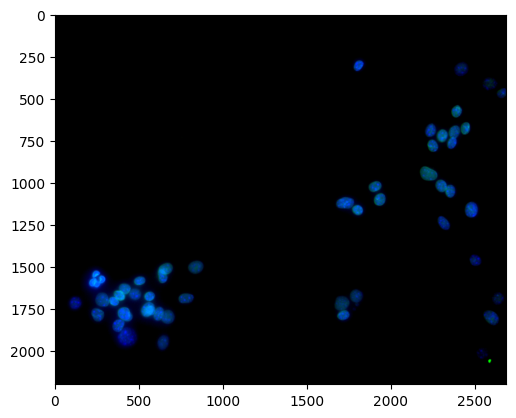

In [ ]:
def segmentation_image(field_dir: Path):
    stains = {
        "laminin B1.tif": {"channel": 1}, # green
        "dapi.tif": {"channel": 2}, # blue
        "GFAP.tif": {"channel": 0}, # red
    }
    images = {}
    images_norm = {}
    for stain_name, info in stains.items():
        image_path = field_dir / stain_name        
        img = io.imread(image_path)  # shape: (H, W, C)
        images[stain_name] = ski.io.imread(image_path)
        channel_idx = info["channel"]
        # Extract single channel, normalize to [0,1]
        single_channel = img[..., channel_idx].astype(np.float32)
        images[stain_name] = single_channel
        # Normalize
        if single_channel.max() > 0:
            single_channel_norm = single_channel / single_channel.max()
        else:
            single_channel_norm = single_channel
        images_norm[stain_name] = single_channel_norm

    # Assuming order: Red, Green, Blue
    height, width = next(iter(images.values())).shape
    # height, width = list(images.values())[0].shape
    composite = np.zeros((height, width, 3), dtype=np.float32)
    composite_normalized = np.zeros((height, width, 3), dtype=np.float32)
    # Assign channels to RGB
    composite[..., 0] = 0 #images["GFAP.tif"]       # Red
    composite[..., 1] = images["laminin B1.tif"] # Green
    composite[..., 2] = images["dapi.tif"]       # Blue

    composite_normalized[..., 0] = 0 #images_norm["GFAP.tif"]       # Red
    composite_normalized[..., 1] = images_norm["laminin B1.tif"] # Green
    composite_normalized[..., 2] = images_norm["dapi.tif"]       # Blue

    return composite, composite_normalized

composite, composite_norm = segmentation_image(images_dir / sample / field)
plt.imshow(composite_norm)


In [33]:
model = models.CellposeModel(gpu=True)

In [ ]:
masks, flows, styles = model.eval(composite_norm)


In [ ]:
def filter_cells(masks, image, threshold=0.1):
    """
    Keep only masks that are alive cells, not debris.
    threshold: 0.1 default, assuming image normalized to [0,1]; otherwise adjust
    """
    # Get the DAPI channel (blue channel, index 2)
    dapi_channel = image[..., 2]

    filtered_masks = []
    # Go through each unique object label
    for label in np.unique(masks):
        if label == 0:
            continue  # skip background
        # Create boolean mask for this object
        mask_region = masks == label
        # Calculate mean DAPI intensity over this region
        mean_intensity = np.mean(dapi_channel[mask_region])
        # Keep only if above threshold
        if mean_intensity < threshold:
            filtered_masks.append(label)
    if filtered_masks:
        print("filtered", filtered_masks)
    masks = fastremap.mask(masks, filtered_masks)
    fastremap.renumber(masks, in_place=True)
    return masks


masks = cellpose.utils.fill_holes_and_remove_small_masks(masks, min_size=1000)
# we'll filter later...
# masks = filter_cells(masks, composite, threshold=0.01)

io.masks_flows_to_seg(composite_norm, masks, flows, f"outputs/{sample}-{field}")
io.save_masks(composite_norm, masks, flows, f"outputs/{sample}-{field}", png=True)

In [ ]:
def plot_segmentation(output: str, img):
    plt.figure() 
    dat = np.load(output + "_seg.npy", allow_pickle=True).item()

    # plot image with masks overlaid
    mask_RGB = cellpose.plot.mask_overlay(
        img, dat['masks'],
    )
    # plt.imshow(mask_RGB)
    # return

    # plot image with outlines overlaid in red
    outlines = cellpose.utils.outlines_list(dat['masks'])
    plt.imshow(img)
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='r')

    # Plot mask labels at their centroids
    for label in np.unique(masks):
        if label == 0:
            continue  # skip background
        mask_region = masks == label
        y, x = np.where(mask_region)
        if len(x) > 0:
            cx, cy = np.mean(x), np.mean(y)
            plt.text(cx, cy, str(label), color='white', fontsize=6, ha='center', va='center')

    plt.axis('off')

    plt.savefig(output + ".seg.png", dpi=300, bbox_inches='tight')
    # to show multiple at once...
    # fig = plt.figure(figsize=(12,5))
    # cellpose.plot.show_segmentation(fig, image, masks, flows)#, channels=channels[idx])
    #plt.tight_layout()
    #plt.show()
    plt.close()



plot_segmentation(f"outputs/{sample}-{field}", composite_norm)


In [ ]:
def cell_stats(masks, image):
    perimeters = cellpose.utils.get_mask_perimeters(masks)
    median_diameter, diameters = cellpose.utils.diameters(masks)

    stats_list = []
    for label in np.unique(masks):
        if label == 0:
            continue  # skip background
        diameter = diameters[label-1]
        perimeter = perimeters[label-1]
        mask_region = masks == label
        area = np.sum(mask_region)  # area in pixels
        # Avoid division by zero
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter else np.nan

        # Compute median intensity per channel
        median_intensities = {}
        channels = [
            (1, "laminin-b1"),
            (2, "dapi"),
            # (0, "gfap"),
        ]
        for index, name in channels:
            channel_values = image[..., index][mask_region]
            median_intensities[f'median_intensity_{name}'] = np.median(channel_values)
            # median_intensities[f'median_intensity_{name}_pc'] = 100 * median_intensities[f'median_intensity_{name}']

        coords_y, coords_x = np.where(masks == label)
    
        stats_list.append({
            'label': label,
            'area': area,
            'perimeter': perimeter,
            'circularity': circularity,
            'diameter': diameter,
            'x': np.mean(coords_x),
            'y': np.mean(coords_y),            
            **median_intensities,
        })
    return stats_list

stats = cell_stats(masks, composite)

In [58]:
stats

[{'label': np.uint16(1),
  'area': np.int64(2976),
  'perimeter': np.float64(206.55129855222071),
  'circularity': np.float64(0.8765706629165463),
  'diameter': np.float64(54.55272678794342),
  'x': np.float64(1804.0793010752689),
  'y': np.float64(305.528561827957),
  'median_intensity_laminin-b1': np.float32(56.0),
  'median_intensity_laminin-b1_pc': np.float32(5600.0),
  'median_intensity_dapi': np.float32(180.0),
  'median_intensity_dapi_pc': np.float32(18000.0)},
 {'label': np.uint16(2),
  'area': np.int64(5953),
  'perimeter': np.float64(288.49242404917504),
  'circularity': np.float64(0.8988286786279414),
  'diameter': np.float64(77.15568676384133),
  'x': np.float64(2416.084327229968),
  'y': np.float64(326.7903578027885),
  'median_intensity_laminin-b1': np.float32(11.0),
  'median_intensity_laminin-b1_pc': np.float32(1100.0),
  'median_intensity_dapi': np.float32(57.0),
  'median_intensity_dapi_pc': np.float32(5700.0)},
 {'label': np.uint16(3),
  'area': np.int64(5362),
  'pe

In [12]:
all_stats = []
done = set()

In [ ]:
# done.update([
#     ("M Cre", "1"),
#     ("M Cre", "4"),
#     ("M Cre", "2"),
#     ("M Cre", "3"),
# ])

for sample in samples:
    for field in sample_fields[sample]:
        print(sample, field)
        if (sample, field) in done:
            continue
        image, image_norm = segmentation_image(images_dir / sample / field)
        masks, flows, styles = model.eval(image_norm)
        masks = cellpose.utils.fill_holes_and_remove_small_masks(masks, min_size=1000)
        masks = filter_cells(masks, image, threshold=0.1)
        output = f"outputs/{sample}-{field}"
        io.masks_flows_to_seg(image_norm, masks, flows, output)
        io.save_masks(image_norm, masks, flows, output, png=True)
        plot_segmentation(image_norm, image)
        Path(output + "_seg.npy").unlink()
        stats = cell_stats(masks, image)
        for s in stats:
            s["sample"] = sample
            s["field"] = field
        all_stats.extend(stats)

        done.add((sample, field))


stats_df = pd.DataFrame(all_stats)
stats_df.to_csv('cells.csv', index=False)


M Cre 1
filtered [np.uint16(1), np.uint16(15), np.uint16(17), np.uint16(19), np.uint16(20), np.uint16(30), np.uint16(32), np.uint16(42)]
M Cre 4
M Cre 3
M Cre 2
filtered [np.uint16(8)]
M Cre 5
M No Cre 1
filtered [np.uint16(28)]
M No Cre 4
M No Cre 3
M No Cre 2
filtered [np.uint16(31)]
M No Cre 5
F Cre 1
F Cre 4
F Cre 3
F Cre 2
F Cre 5
F no cre 1
filtered [np.uint16(9), np.uint16(21), np.uint16(23), np.uint16(24), np.uint16(29), np.uint16(37)]
F no cre 4
filtered [np.uint16(11)]
F no cre 3
F no cre 2
filtered [np.uint16(11)]
F no cre 5
filtered [np.uint16(88)]


In [ ]:
# to avoid rerunning the whole segmentation
stats_df = pd.read_csv("cells.csv")

In [7]:
cell_counts = stats_df.groupby(['sample', 'field']).size().reset_index(name='num_cells')
print(cell_counts)

      sample  field  num_cells
0      F Cre      1         43
1      F Cre      2         39
2      F Cre      3         50
3      F Cre      4         85
4      F Cre      5         55
5   F no cre      1         45
6   F no cre      2         14
7   F no cre      3         21
8   F no cre      4         22
9   F no cre      5         91
10     M Cre      1         34
11     M Cre      2         28
12     M Cre      3         88
13     M Cre      4         73
14     M Cre      5         77
15  M No Cre      1         33
16  M No Cre      2         48
17  M No Cre      3         26
18  M No Cre      4         27
19  M No Cre      5         24


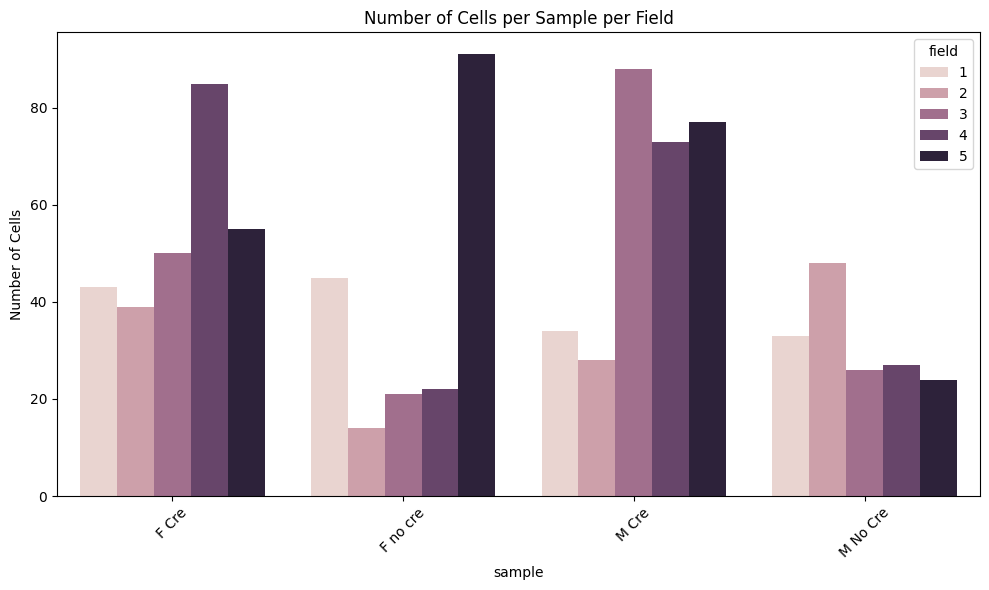

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=cell_counts, x='sample', y='num_cells', hue='field')
plt.title('Number of Cells per Sample per Field')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Add sample group labels if needed (M/F, Cre/No Cre)
# For example, split 'sample' like:
stats_df['sex'] = stats_df['sample'].str[0]  # 'M' or 'F'
stats_df['cre_status'] = stats_df['sample'].str[2:]  # 'Cre' or 'No Cre'

In [17]:
stats_df

,label,area,perimeter,circularity,diameter,x,y,median_intensity_laminin-b1,median_intensity_dapi,sample,field,sex,cre_status
0,1,4537,256.007143,0.869910,67.357256,1216.599295,725.973992,0.262745,0.152941,M Cre,1,M,Cre
1,2,3420,230.308658,0.810243,58.480766,1259.355556,766.391520,0.301961,0.243137,M Cre,1,M,Cre
2,3,3633,251.965512,0.719106,60.274373,1087.182494,820.498211,0.266667,0.160784,M Cre,1,M,Cre
3,4,3812,238.166522,0.844503,61.741396,1135.377230,827.029381,0.290196,0.282353,M Cre,1,M,Cre
4,5,6168,294.249783,0.895204,78.536616,1462.430447,865.761349,0.384314,0.325490,M Cre,1,M,Cre
...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,87,4385,244.208153,0.923973,66.219333,1753.193615,1935.068187,0.211765,0.490196,F no cre,5,F,no cre
919,88,5030,270.249783,0.865460,70.922493,1922.860239,1974.323857,0.258824,0.556863,F no cre,5,F,no cre
920,89,6302,306.291414,0.844148,79.385137,1861.152809,1997.596001,0.270588,0.411765,F no cre,5,F,no cre
921,90,5578,288.634560,0.841379,74.686009,1894.590893,2098.889925,0.152941,0.392157,F no cre,5,F,no cre


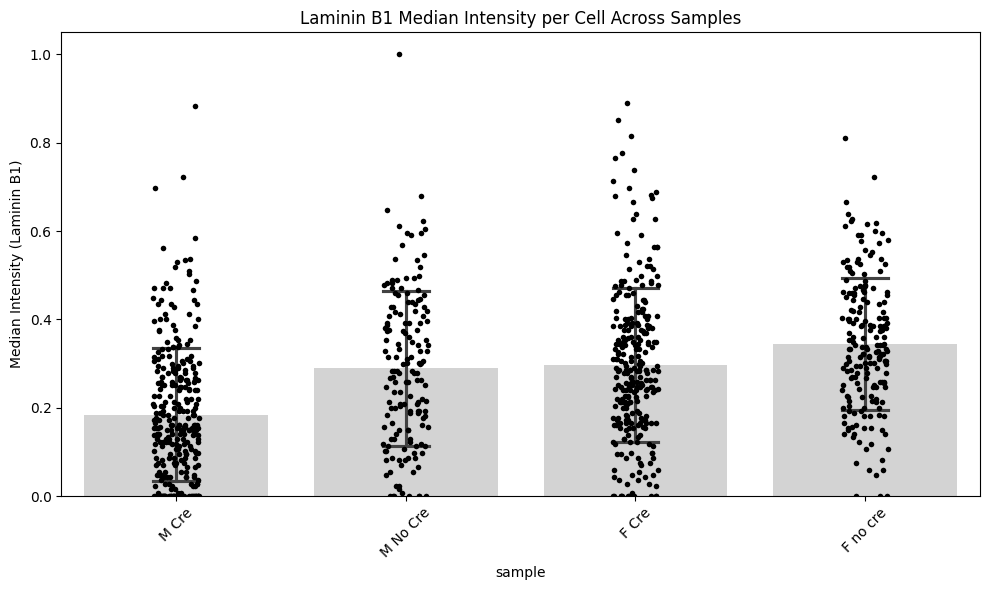

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=stats_df, 
    x='sample', 
    y='median_intensity_laminin-b1', 
    errorbar='sd', # 68 for SEM
    capsize=0.2,
    color='lightgray'
)
sns.stripplot(
    data=stats_df, 
    x='sample', 
    y='median_intensity_laminin-b1', 
    color='black', 
    size=4, 
    jitter=True
)
plt.title('Laminin B1 Median Intensity per Cell Across Samples')
plt.ylabel('Median Intensity (Laminin B1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


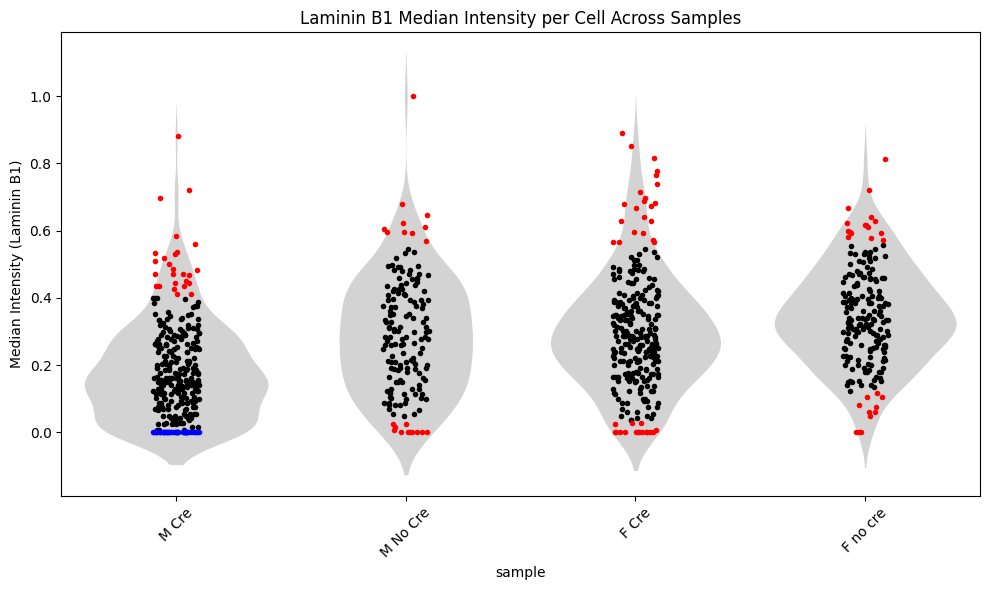

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Copy to avoid modifying original
plot_df = stats_df.copy()

# Calculate outliers per sample and 0 (not outliers)
def mark_outliers_per_sample(df, col='median_intensity_laminin-b1'):
    df = df.copy()
    df["is_outlier"] = False
    df["is_zero"] = False  # sera défini après

    for sample, group in df.groupby("sample"):
        mean = group[col].mean()
        std = group[col].std()
        upper = mean + 1.5 * std
        lower = mean - 1.5 * std

        is_outlier = (group[col] > upper) | (group[col] < lower)
        df.loc[group.index, "is_outlier"] = is_outlier

    # mark values == 0 that are not outliers
    df["is_zero"] = (df[col] == 0) & (~df["is_outlier"])

    return df


plot_df = mark_outliers_per_sample(plot_df)

# === PLOT ===
plt.figure(figsize=(10, 6))

# (Optional) violin plot – comment out this line to remove
sns.violinplot(
    data=plot_df,
    x='sample',
    y='median_intensity_laminin-b1',
    inner=None,
    linewidth=0,
    color='lightgray'
)

# Barplot (mean + SD)
# sns.barplot(
#     data=plot_df,
#     x='sample',
#     y='median_intensity_laminin-b1',
#     errorbar='sd',
#     capsize=0.2,
#     color='lightgray'
# )

# Normal points (not outliers)
sns.stripplot(
    data=plot_df[(~plot_df["is_outlier"]) & (~plot_df["is_zero"])],
    x='sample',
    y='median_intensity_laminin-b1',
    color='black',
    size=4,
    jitter=True
)

# value = 0 in blue
sns.stripplot(
    data=plot_df[plot_df["is_zero"]],
    x='sample',
    y='median_intensity_laminin-b1',
    color='blue',
    size=4,
    jitter=True
)

# Outlier points (in red)
sns.stripplot(
    data=plot_df[plot_df["is_outlier"]],
    x='sample',
    y='median_intensity_laminin-b1',
    color='red',
    size=4,
    jitter=True
)

plt.title('Laminin B1 Median Intensity per Cell Across Samples')
plt.ylabel('Median Intensity (Laminin B1)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [73]:
# Export CSV
plot_df["formatted_value"] = plot_df.apply(
    lambda row: f"**{row['median_intensity_laminin-b1']}**" if row["is_outlier"] or row["is_zero"] else str(row["median_intensity_laminin-b1"]),
    axis=1
)

plot_df[["sample", "label", "median_intensity_laminin-b1", "formatted_value", "is_outlier", "is_zero"]].to_csv("laminin_intensity_outliers.csv", index=False)


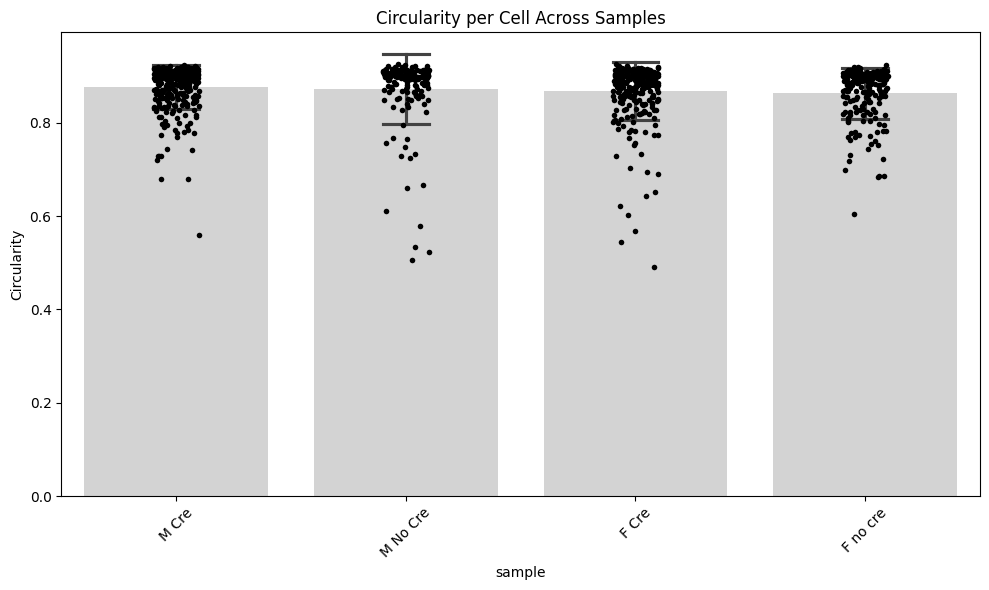

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=stats_df, 
    x='sample', 
    y='circularity', 
    errorbar='sd', # 68 for SEM
    capsize=0.2,
    color='lightgray'
)
sns.stripplot(
    data=stats_df, 
    x='sample', 
    y='circularity', 
    color='black', 
    size=4, 
    jitter=True
)
plt.title('Circularity per Cell Across Samples')
plt.ylabel('Circularity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


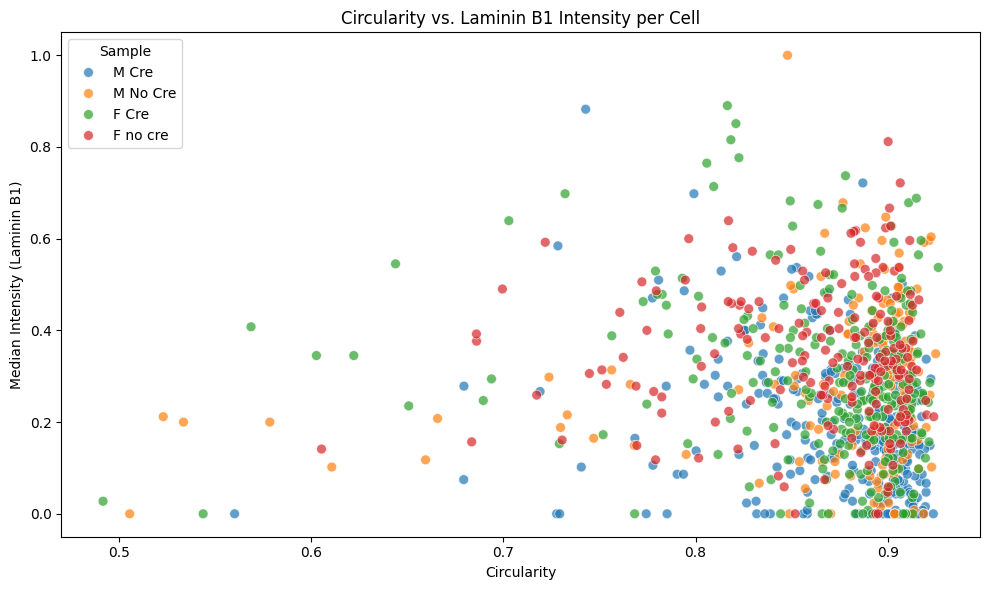

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=stats_df,
    x='circularity',
    y='median_intensity_laminin-b1',  # adjust this column name if needed
    hue='sample',
    palette='tab10',  # or another seaborn palette
    s=50,  # point size
    alpha=0.7
)

plt.title('Circularity vs. Laminin B1 Intensity per Cell')
plt.xlabel('Circularity')
plt.ylabel('Median Intensity (Laminin B1)')
plt.legend(title='Sample')
plt.tight_layout()
plt.show()
